In [5]:
# Imports

# File handling
import os
import pathlib
import cv2

# Visualization
import pandas as pd
#import  matplotlib.pyplot as plt
#%matplotlib inline

# NumPy
import numpy as np

# ML
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.optimizers import Adam

#from keras import layers
#from keras.callbacks import CSVLogger
from keras.utils import image_dataset_from_directory

from sklearn.utils import shuffle
#from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score #, confusion_matrix, classification_report
from sensitivity import SensitivityAnalyzer

In [46]:
def load_model(file="model18.h5", hist="18_history.csv"):
    
    # load model and history
    
    import tensorflow as tf
    import pandas as pd
    import numpy as np
    model = tf.keras.models.load_model(file)
    history = pd.read_csv(hist)[['loss','binary_accuracy', 'val_loss', 'val_binary_accuracy']]
    return model, history

def get_data(train_path='images/train/', test_path='images/test/', valid_path='images/val/', size=(256, 256), batch_size=1):
    
    # preprocess train, test and valid sets
    
    from keras.utils import image_dataset_from_directory
    train = image_dataset_from_directory(directory=train_path,
                             label_mode='binary',
                             color_mode="rgb",
                             image_size=size,
                             batch_size=batch_size,
                             shuffle=True,
                             seed=77)
    test = image_dataset_from_directory(directory=test_path,
                             color_mode="rgb",
                             label_mode='binary',
                             image_size=size,
                             batch_size=batch_size,
                             shuffle=False,
                             seed=77)
    valid = image_dataset_from_directory(directory=valid_path,
                             color_mode="rgb",
                             label_mode='binary',
                             image_size=size,
                             batch_size=batch_size,
                             shuffle=False,
                             seed=77)
    return train, test, valid

def evaluate_model(model, n, valid, test):
    
    pd.DataFrame(model.history.history).plot(figsize=(15,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.title(f'Model {n} Learning Curves')
    plt.show()
    print()
    print()
    print()
    print('Test set score')
    print()
    model.evaluate(test)
    print()
    print()
    print()
    print('Validation set score')
    print()
    model.evaluate(valid)

def dim_info(dimension):
    print("Dimension type: ", type(dimension))
    print("Dimension length: ", len(dimension))
    
def garson(A, B):
    # reference: https://csiu.github.io/blog/update/2017/03/29/day33.html
    """
    Computes Garson's algorithm
    A = matrix of weights of input-hidden layer (rows=input & cols=hidden)
    B = vector of weights of hidden-output layer
    """
    B = np.diag(B)

    # connection weight through the different hidden node
    cw = np.dot(A, B)
    cw = cw[1]
    # weight through node (axis=0 is column; sum per input feature)
    cw_h = abs(cw).sum()#axis=0)

    # relative contribution of input neuron to outgoing signal of each hidden neuron
    # sum to find relative contribution of input neuron
    rc = np.divide(abs(cw), abs(cw_h))
    rc = rc.sum(axis=1)

    # normalize to 100% for relative importance
    ri = rc / rc.sum()
    return(ri)

def images_to_arrays(folder_path):
    X = []
    y = []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if not os.path.isdir(class_path):
            continue
        class_label = class_folder  # Assign the class folder name as the label
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (256, 256))  # Resize the image
                img_array = np.array(img, dtype=np.float32)  # Convert array values to float
                X.append(img_array)
                y.append(class_label)
    return np.array(X), np.array(y)

In [3]:
X_train, y_train = images_to_arrays("images\\train")
X_test, y_test = images_to_arrays("images\\test")
X_train_flat = X_train.reshape(X_train.shape[0], -1) # train data input for logreg and knn
X_test_flat = X_test.reshape(X_test.shape[0], -1) # test data input for logreg and knn

#X_valid, y_valid = images_to_arrays("images\\val")

In [14]:
# logistic regression classifier
logreg = LogisticRegression(max_iter=50)
logreg.fit(X_train_flat, y_train)
y_pred_logreg = logreg.predict(X_test_flat)
print("Logistic Regression Classifier accuracy: ", logreg.score(X_test_flat, y_test))

Logistic Regression Classifier accuracy:  0.8160377358490566


In [6]:
# KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_flat, y_train)
y_pred_knn = knn.predict(X_test_flat)
print("K-Nearest-Neighbour Classifier accuracy: ", accuracy_score(y_test, y_pred_knn))

K-Nearest-Neighbour Classifier accuracy:  0.8537735849056604


In [ ]:
knn_sens_analysis_results = garson(X_test_flat, y_pred_knn)

In [107]:
# data
train, test, valid = get_data()

Found 16930 files belonging to 2 classes.
Found 2120 files belonging to 2 classes.
Found 2115 files belonging to 2 classes.


In [7]:
# model
model = load_model()[0]
weights = model.get_weights()

In [47]:
# sensitivity analysis
inp_weights = model.get_layer('conv2d').get_weights()
outp_weights = model.get_layer('dense').get_weights()
sens_analysis_results = garson(inp_weights, outp_weights)
sens_analysis_results

array([[[2.30734877e-04, 1.87012814e-02, 1.13367270e-04, 3.97640513e-04,
         3.31877498e-03, 1.86749531e-07, 4.46310616e-04, 4.58863273e-04,
         2.03656353e-04, 6.85350737e-04, 4.67900691e-07, 9.62785293e-07,
         5.13517407e-05, 2.49966397e-04, 1.58234173e-03, 1.48213806e-03,
         2.90566823e-04, 7.00122037e-04, 5.54495957e-04, 1.01767946e-02,
         1.22092701e-02, 4.54057800e-03, 9.24448832e-05, 4.55868489e-04,
         1.96221191e-02, 9.93989088e-05, 1.02363736e-03, 3.06386995e-04,
         6.42934861e-03, 1.03207405e-07, 1.16480710e-08, 7.50859501e-04,
         6.62071398e-04, 9.59886961e-08, 1.91142433e-04, 1.05668230e-09,
         3.92274075e-07, 7.87308745e-05, 1.12975622e-03, 5.19411115e-04,
         9.75869538e-04, 4.13821108e-04, 4.72121092e-11, 1.97928983e-07,
         1.52654582e-04, 1.91446481e-04, 2.30417034e-04, 2.42784987e-10,
         3.41997453e-04, 3.18493752e-04, 9.39502101e-03, 3.11909041e-08,
         4.35502362e-03, 5.60628599e-04, 1.63466285

## Model 18 -- Best

In [6]:
shape = (256, 256, 3)
drop = 0.6
kernel = (3, 3)
pool = (2, 2)
num_classes=2
regularizer=keras.regularizers.l2(0.01)
learning_rate=0.0017

model18 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=shape), # input
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(1, activation="sigmoid") # output
    ])

model18.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model18.fit(train, validation_data=valid, verbose=1, epochs=50, shuffle=True, callbacks=[early_stopping_cb])

Epoch 1/50
530/530 [==============================] - 146s 274ms/step - loss: 0.5872 - binary_accuracy: 0.7271 - val_loss: 0.4648 - val_binary_accuracy: 0.7948
Epoch 2/50
530/530 [==============================] - 145s 273ms/step - loss: 0.4833 - binary_accuracy: 0.7856 - val_loss: 0.4433 - val_binary_accuracy: 0.8024
Epoch 3/50
530/530 [==============================] - 145s 273ms/step - loss: 0.4585 - binary_accuracy: 0.8004 - val_loss: 0.4319 - val_binary_accuracy: 0.8076
Epoch 4/50
530/530 [==============================] - 145s 272ms/step - loss: 0.4545 - binary_accuracy: 0.8058 - val_loss: 0.4077 - val_binary_accuracy: 0.8213
Epoch 5/50
530/530 [==============================] - 144s 272ms/step - loss: 0.4440 - binary_accuracy: 0.8108 - val_loss: 0.4301 - val_binary_accuracy: 0.8165
Epoch 6/50
530/530 [==============================] - 145s 272ms/step - loss: 0.4358 - binary_accuracy: 0.8151 - val_loss: 0.4100 - val_binary_accuracy: 0.8265
Epoch 7/50
530/530 [====================

In [135]:
model18.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

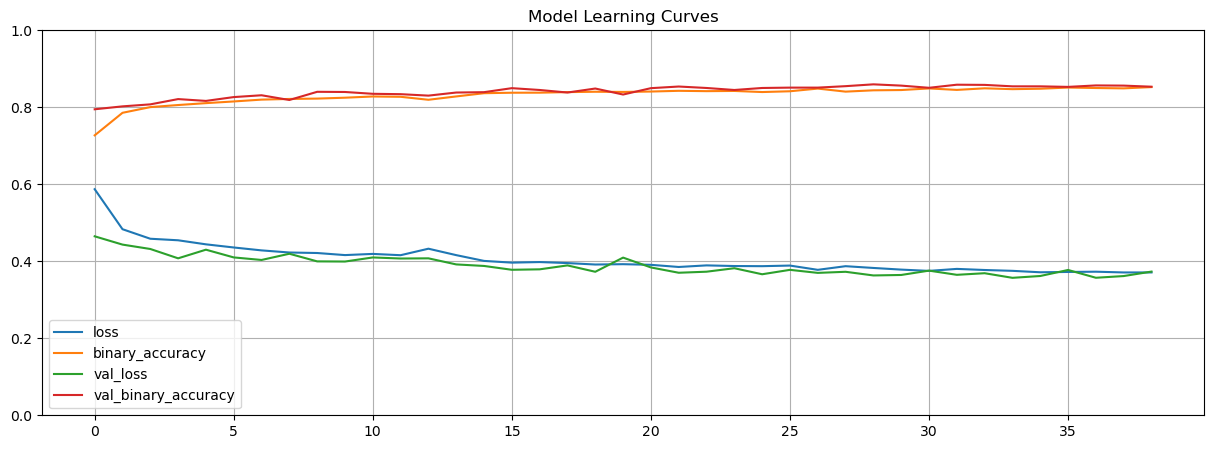




Test set score

67/67 [==============================] - 5s 75ms/step - loss: 0.3481 - binary_accuracy: 0.8656



Validation set score

67/67 [==============================] - 5s 74ms/step - loss: 0.3570 - binary_accuracy: 0.8544


In [76]:
evaluate_model(model18)

## Model 16 train log

In [30]:
model16 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3)), # input
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(num_classes, activation="softmax") # output
    ])

model16.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model16.fit(train, validation_data=valid, verbose=1, epochs=50, shuffle=True, callbacks=[early_stopping_cb])

Epoch 1/50
530/530 [==============================] - 151s 284ms/step - loss: 1.1508 - accuracy: 0.7456 - val_loss: 0.5558 - val_accuracy: 0.7400
Epoch 2/50
530/530 [==============================] - 148s 279ms/step - loss: 0.5366 - accuracy: 0.7741 - val_loss: 0.4956 - val_accuracy: 0.8005
Epoch 3/50
530/530 [==============================] - 147s 277ms/step - loss: 0.5193 - accuracy: 0.7853 - val_loss: 0.4773 - val_accuracy: 0.8123
Epoch 4/50
530/530 [==============================] - 146s 274ms/step - loss: 0.5089 - accuracy: 0.7901 - val_loss: 0.4731 - val_accuracy: 0.8213
Epoch 5/50
530/530 [==============================] - 146s 276ms/step - loss: 0.5001 - accuracy: 0.7980 - val_loss: 0.4634 - val_accuracy: 0.8222
Epoch 6/50
530/530 [==============================] - 146s 275ms/step - loss: 0.4955 - accuracy: 0.7996 - val_loss: 0.4622 - val_accuracy: 0.8165
Epoch 7/50
530/530 [==============================] - 146s 275ms/step - loss: 0.4925 - accuracy: 0.8012 - val_loss: 0.4566 -

## Models

model 1: loss: 0.6931 - accuracy: 0.4816 - val_loss: 0.6931 - val_accuracy: 0.4818  

model 2: loss: 8.3040 - accuracy: 0.4834 (interrupted)  

model 3: loss: 7.7412 - accuracy: 0.5178 - val_loss: 7.7656 - val_accuracy: 0.5182 (interrupted)  

model 4: loss: 0.7825 - accuracy: 0.4816 - val_loss: 0.6931 - val_accuracy: 0.4818  

model 5: loss: 0.4360 - accuracy: 0.8014 - val_loss: 0.4345 - val_accuracy: 0.8052  

model 6: loss: 0.4879 - accuracy: 0.7790 - val_loss: 0.4714 - val_accuracy: 0.7721  

model 7: loss: 0.3973 - accuracy: 0.8236 - val_loss: 0.4227 - val_accuracy: 0.8132  

model 8: loss: 0.0499 - accuracy: 0.9820 - val_loss: 0.6409 - val_accuracy: 0.8771  

model 10: loss: 0.4822 - accuracy: 0.8227 - val_loss: 0.4620 - val_accuracy: 0.8388

model 11: loss: 0.8762 - accuracy: 0.5212

model 12: loss: 0.5320 - accuracy: 0.8244 (14/25)

model 14: loss: 0.7177 - accuracy: 0.5157 - val_loss: 0.7177 - val_accuracy: 0.5182  

model 15 : loss: 0.7157 - accuracy: 0.4834 (interrupted)  

model 16: loss: 0.4366 - accuracy: 0.8351 - val_loss: 0.4091 - val_accuracy: 0.8459 (50 epochs)  

model 17: loss: 0.5579 - accuracy: 0.7285 - val_loss: 0.5146 - val_accuracy: 0.7688 (2 epochs!!)  

model 18: loss: 0.3710 - binary_accuracy: 0.8525 - val_loss: 0.3732 - val_binary_accuracy: 0.8534 (50 epochs!!!)  # increased learning rate, l2 regulariztion, binary classification

model 19: loss: 0.5588 - binary_accuracy: 0.7324 - val_loss: 0.4958 - val_binary_accuracy: 0.7759 (2 epochs!)  

model 20: loss: 0.7127 - binary_accuracy: 0.5910(interrupted)  

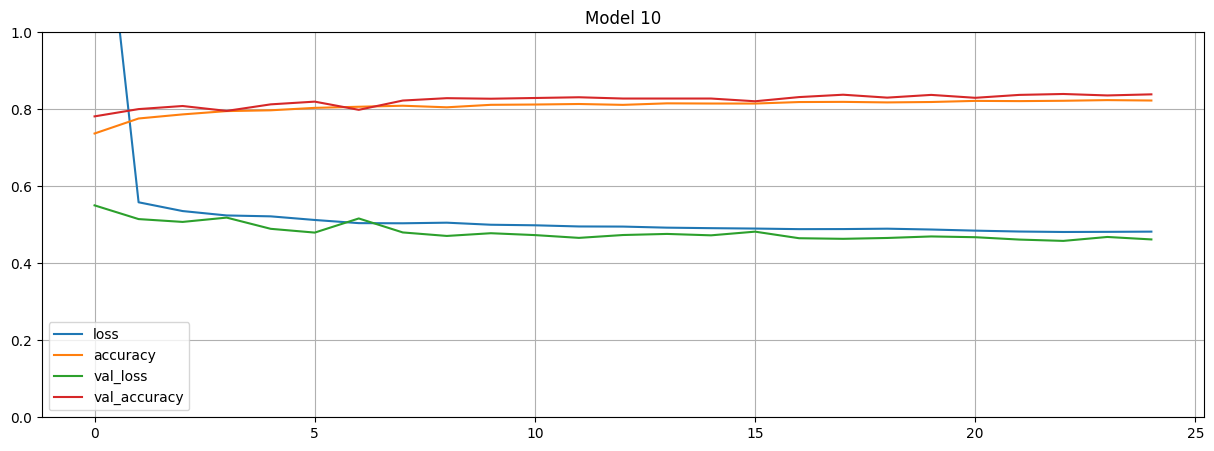

```
Test set score

67/67 [==============================] - 197s 3s/step - loss: 0.4495 - accuracy: 0.8458

Validation set score

67/67 [==============================] - 7s 97ms/step - loss: 0.4620 - accuracy: 0.8388
```

In [ ]:
shape = (256, 256, 3)
drop = 0.6
kernel = (3, 3)
pool = (2, 2)
regularizer=keras.regularizers.l2(0.01)
learning_rate=0.0017
num_classes=2

model1 = keras.Sequential(
    [
        layers.Rescaling(1./255, input_shape=input_shape),
                         
        layers.Conv2D(16, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(pool_size=(2, 2)),
                         
        layers.Conv2D(32, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(64, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(), # Dimensionality reduction (feature map)
        layers.Dropout(0.5), # Output layer
        layers.Dense(num_classes) # fully connected layer
    ])

model1.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2 = keras.Sequential(
    [
        layers.Rescaling(1./255, input_shape=input_shape),
                         
        layers.Conv2D(32, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Flatten(), # Dimensionality reduction (feature map)
        layers.Dropout(0.5), # Output layer
        layers.Dense(num_classes) # fully connected layer
    ])

model2.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model3 = keras.Sequential(
    [
        layers.Rescaling(1./255, input_shape=input_shape),
                         
        layers.Conv2D(32, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Flatten(), # Dimensionality reduction (feature map)
        layers.Dropout(0.5), # Output layer
        layers.Dense(num_classes) # fully connected layer
    ])

model3.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model4 = keras.Sequential(
    [
        layers.Rescaling(1./255, input_shape=input_shape),
                         
        layers.Conv2D(32, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Conv2D(128, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Flatten(), # Dimensionality reduction (feature map)
        layers.Dropout(0.5), # Output layer
        layers.Dense(num_classes) # fully connected layer
    ])

model4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model4 = keras.Sequential(
    [
        layers.Rescaling(1./255, input_shape=input_shape),
                         
        layers.Conv2D(32, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Conv2D(128, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Flatten(), # Dimensionality reduction (feature map)
        layers.Dropout(0.5), # Output layer
        layers.Dense(num_classes) # fully connected layer
    ])

model4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model5 = keras.Sequential(
    [
        layers.Rescaling(1./255, input_shape=shape), # input
        layers.Flatten(),
        
        layers.Dense(300, activation="relu"), # layer
        layers.Flatten(),
        
        layers.Dense(100, activation="relu"), # layer
        layers.Flatten(),
        
        layers.Dense(num_classes, activation="sigmoid") # output
    ])

model5.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model6 = keras.Sequential(
    [
        layers.Rescaling(1./255, input_shape=shape), # input
        layers.Flatten(),
        
        layers.Dense(300, activation="relu"), # layer
        layers.Flatten(),
        
        layers.Dense(100, activation="relu"), # layer
        layers.Flatten(),
        
        layers.Dense(num_classes, activation="softmax") # output
    ])

model6.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model7 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=shape), # input
        layers.Flatten(),
        
        layers.Dense(200, activation="relu"), # layer
        layers.Flatten(),
        
        layers.Dense(100, activation="relu"), # layer
        layers.Flatten(),

        layers.Dense(100, activation="relu"), # layer
        layers.Flatten(),
        
        layers.Dense(num_classes, activation="softmax") # output
    ])

model7.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model8 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3)), # input
        layers.MaxPooling2D(2),
     
        layers.Conv2D(200, kernel_size=(3, 3), activation="relu"), # layer
        layers.MaxPooling2D(2),
        
        layers.Conv2D(150, kernel_size=(3, 3), activation="relu"), # layer
        layers.MaxPooling2D(2),

        layers.Conv2D(50, kernel_size=(3, 3), activation="relu"), # layer
        layers.MaxPooling2D(2),
        layers.Flatten(),
        
        layers.Dense(num_classes, activation="softmax") # output
    ])

model8.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model9 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=shape), # input
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(200, kernel_size=kernel, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(num_classes) # output
    ])

model9.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model10 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3)), # input
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(200, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(50, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(num_classes) # output
    ])

model10.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])#20 epochs

model14 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3)), # input
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(num_classes, actication="softmax") # output
    ])

model14.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model14.fit(train, validation_data=valid, verbose=1, epochs=50, shuffle=True, callbacks=[early_stopping_cb])

model15 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3)), # input
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        layers.Dropout(drop),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        layers.Dropout(drop),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(num_classes) # output
    ])

model15.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model15.fit(train, validation_data=valid, verbose=1, epochs=50, shuffle=True, callbacks=[early_stopping_cb])

model16 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3)), # input
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(num_classes, activation="softmax") # output
    ])

model16.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model16.fit(train, validation_data=valid, verbose=1, epochs=50, shuffle=True, callbacks=[early_stopping_cb])

model17 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3)),
        layers.Resizing(128, 128), # input
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(num_classes, activation="softmax") # output
    ])

model17.compile(optimizer=Adam(learning_rate=0.00164),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model17.summary()

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model17.fit(train, validation_data=valid, verbose=1, epochs=2, shuffle=True, callbacks=[early_stopping_cb])

model18 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=shape), # input
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(1, activation="sigmoid") # output
    ])

model18.compile(optimizer=Adam(learning_rate=0.0017),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model18.fit(train, validation_data=valid, verbose=1, epochs=50, shuffle=True, callbacks=[early_stopping_cb])

model19 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3)), # input
        layers.Resizing(128, 128),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(1, activation="sigmoid") # output
    ])

model19.compile(optimizer=Adam(learning_rate=0.00164),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

model20 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3), name='input'), # input
        layers.Resizing(128, 128),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu", name='layer1'), # layer
        layers.MaxPooling2D(pool_size=pool),
                
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu", name='layer2'), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.GlobalMaxPooling2D(name="global_maxpooling"),
        
        layers.Flatten(),
        
        layers.Dense(1, activation="sigmoid", name='output') # output
    ])
model20.compile(optimizer=Adam(learning_rate=0.0018),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [ ]:
valid_l = list(valid.as_numpy_iterator())
X_valid = np.array([])
y_valid = np.array([])

for element in valid_l:
    X_valid = np.append(X_valid, element[0][0][0])
    y_valid = np.append(y_valid, element[1][0][0][0])

In [ ]:
train_l = list(train.as_numpy_iterator())
X_train = np.array([])
y_train = np.array([])

for element in train_l:
    X_train = np.append(X_train, element[0][0][0])
    y_train = np.append(y_train, element[1][0][0][0])

In [ ]:
test_l = list(test.as_numpy_iterator())
X_test = np.array([])
y_test = np.array([])

for element in test_l:
    X_test = np.append(X_test, element[0][0][0])
    y_test = np.append(y_test, element[1][0][0][0])

In [15]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)